In [1]:
%load_ext autoreload
%autoreload 2

# Encoder & Decoder of genetic circuits

In this notebook, we will construct an encoder-decoder to create a representation space that correlates with topologies or motifs in a genetic circuit.

Inspired by [Generative aptamer discovery using RaptGen](https://www.nature.com/articles/s43588-022-00249-6#Fig1).

## Imports

In [2]:
# %env XLA_PYTHON_CLIENT_ALLOCATOR=platform

from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.data.data_format_tools.common import write_json
from synbio_morpher.utils.misc.string_handling import prettify_keys_for_label
from typing import List
from functools import partial

import gc
import os
import sys
import numpy as np
import haiku as hk
import jax
import jax.numpy as jnp
import equinox as eqx
import optax  # https://github.com/deepmind/optax
from jaxtyping import Array, Float, Int  # https://github.com/google/jaxtyping

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import r2_score  
                
import wandb

from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'gpu')


# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)


jax.devices()

I0000 00:00:1701952054.493926  284775 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


[gpu(id=0)]

In [3]:
from src.models.mlp import MLP, MLP_fn
from src.losses.losses import loss_fn, compute_accuracy_categorical, compute_accuracy_regression
from src.utils.math import convert_to_scientific_exponent
from src.utils.data_preprocessing import drop_duplicates_keep_first_n

## Load data

In [4]:
fn = '../data/processed/ensemble_mutation_effect_analysis/2023_07_17_105328/tabulated_mutation_info.csv'
fn_test_data = '../data/raw/ensemble_mutation_effect_analysis/2023_10_03_204819/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
try:
    data.drop(columns=['Unnamed: 0'], inplace=True)
except:
    pass

# Encoder

We will use a simple MLP for the encoder and decoder. There are several options for the head, but for now, we will use regression.

## Hyperparameters

In [5]:
BATCH_SIZE = 128
N_BATCHES = 1200
TOTAL_DS = BATCH_SIZE * N_BATCHES
MAX_TOTAL_DS = TOTAL_DS
TRAIN_SPLIT = 0.8
LEARNING_RATE = 5e-4
LEARNING_RATE_SCHED = 'cosine_decay'
# LEARNING_RATE_SCHED = 'constant'
WARMUP_EPOCHS = 20
L2_REG_ALPHA = 0.01
EPOCHS = 5000
PRINT_EVERY = EPOCHS // 10
SEED = 1
INPUT_SPECIES = 'RNA_1'
target_circ_func = 'sensitivity_wrt_species-6'
input_concat_diffs = False
input_concat_axis = 0

# MLP Architecture
LAYER_SIZES = [128, 64, 32, 64, 128]
USE_CATEGORICAL = False
USE_DROPOUT = False
USE_L2_REG = False
USE_WARMUP = False

loss_fn = partial(
    loss_fn, loss_type='categorical' if USE_CATEGORICAL else 'mse', use_l2_reg=USE_L2_REG)
compute_accuracy = compute_accuracy_categorical if USE_CATEGORICAL else compute_accuracy_regression

subtask = '_test'
save_path = str(datetime.now()).split(' ')[0].replace(
    '-', '_') + '__' + str(datetime.now()).split(' ')[-1].split('.')[0].replace(':', '_') + '_saves' + subtask
save_path = os.path.join('weight_saves', '08_encoder_decoder', save_path)

rng = jax.random.PRNGKey(SEED)

## Initialise

### Input

In [6]:
vectorized_convert_to_scientific_exponent = np.vectorize(
    convert_to_scientific_exponent)
filt = data['sample_name'] == INPUT_SPECIES
numerical_resolution = 2

# Balance the dataset
df = drop_duplicates_keep_first_n(data[filt], get_true_interaction_cols(
    data, 'energies', remove_symmetrical=True), n=100)
df[target_circ_func] = df[target_circ_func].round(
    np.abs(int(f'{df[target_circ_func].min():.0e}'.split('e')[1]))-1)
df = drop_duplicates_keep_first_n(
    df, column=target_circ_func, n=200)

TOTAL_DS = np.min([TOTAL_DS, MAX_TOTAL_DS, len(df)])
N_BATCHES = TOTAL_DS // BATCH_SIZE
TOTAL_DS = N_BATCHES * BATCH_SIZE

In [53]:
x_cols = [get_true_interaction_cols(data, 'energies', remove_symmetrical=True)]

x = [df[i].iloc[:TOTAL_DS].values[:, :, None] for i in x_cols]
x = np.concatenate(x, axis=input_concat_axis+1).squeeze()

y = x

x, y = shuffle(x, y, random_state=SEED)

N_HEAD = x.shape[1]


if x.shape[0] < TOTAL_DS:
    print(
        f'WARNING: The filtered data is not as large as the requested total dataset size: {x.shape[0]} vs. requested {TOTAL_DS}')

In [54]:
xscaler, yscaler = MinMaxScaler(), MinMaxScaler()
x = xscaler.fit_transform(x)
y = xscaler.fit_transform(y)

### Initialise WandB

In [8]:
wandb.init(
    # set the wandb project where this run will be logged
    project="test_encoder_decoder",
    # track hyperparameters and run metadata
    config={
        "architecture": "MLP",
        "dataset": "Circuits",
        "epochs": EPOCHS,
        "input_species": INPUT_SPECIES,
        "input_concat_diffs": input_concat_diffs,
        "input_concat_axis": input_concat_axis,
        "layer_sizes": LAYER_SIZES,
        "learning_rate": LEARNING_RATE,
        "learning_rate_schedule": LEARNING_RATE_SCHED,
        "n_head": N_HEAD,
        "seed": SEED,
        "target_circuit_function": target_circ_func,
        "total_dataset_size": TOTAL_DS,
        "train_split_percentage": TRAIN_SPLIT,
        "use_categorical": USE_CATEGORICAL,
        "use_dropout": USE_DROPOUT,
        "use_L2_reg": USE_L2_REG,
        "use_warmup": USE_WARMUP,
        "warmup_epochs": WARMUP_EPOCHS
    }
)

### Initialise model

In [55]:
model = hk.transform(partial(MLP_fn, init_kwargs={
                     'layer_sizes': LAYER_SIZES, 'n_head': N_HEAD, 'use_categorical': USE_CATEGORICAL}))

params = model.init(rng, x[:2])

/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/haiku/_src/initializers.py:126: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(
/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/haiku/_src/base.py:682: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


### Optimiser

In [10]:
if LEARNING_RATE_SCHED == 'cosine_decay':
    learning_rate_scheduler = optax.cosine_decay_schedule(
        LEARNING_RATE, decay_steps=EPOCHS, alpha=L2_REG_ALPHA)
else:
    learning_rate_scheduler = LEARNING_RATE
optimiser = optax.sgd(learning_rate=learning_rate_scheduler)

if USE_WARMUP:
    warmup_fn = optax.linear_schedule(
        init_value=0., end_value=LEARNING_RATE,
        transition_steps=WARMUP_EPOCHS * N_BATCHES)
    cosine_epochs = max(EPOCHS - WARMUP_EPOCHS, 1)
    cosine_fn = optax.cosine_decay_schedule(
        init_value=LEARNING_RATE,
        decay_steps=cosine_epochs * N_BATCHES)
    schedule_fn = optax.join_schedules(
        schedules=[warmup_fn, cosine_fn],
        boundaries=[WARMUP_EPOCHS * N_BATCHES])
    optimiser = optax.sgd(learning_rate=schedule_fn)

optimiser_state = optimiser.init(x)

# Train

In [56]:
# [i_batch, xy, Batches, *content]
        
x = x.reshape(N_BATCHES, 1, BATCH_SIZE, x.shape[-1])
y = y.reshape(N_BATCHES, 1, BATCH_SIZE, y.shape[-1])

x_train, y_train = x[:int(TRAIN_SPLIT * N_BATCHES)], y[:int(TRAIN_SPLIT * N_BATCHES)]
x_val, y_val = x[int(TRAIN_SPLIT * N_BATCHES):], y[int(TRAIN_SPLIT * N_BATCHES):]
xy_train = np.concatenate([x_train, y_train], axis=1)


In [12]:
def train_step(params, x, y, optimiser_state, model, rng, l2_reg_alpha, optimiser):

    loss, grads = jax.value_and_grad(loss_fn)(
        params, rng, model, x, y, l2_reg_alpha=l2_reg_alpha)

    updates, optimiser_state = optimiser.update(grads, optimiser_state)
    params = optax.apply_updates(params, updates)

    return params, optimiser_state, loss, grads


def eval_step(params, rng, model: MLP, x, y, l2_reg_alpha):
    """ Return the average of loss and accuracy on validation data """
    loss = loss_fn(params, rng, model, x, y, l2_reg_alpha=l2_reg_alpha)
    acc = compute_accuracy(params, rng, model, x, y)
    return acc, loss


def run_batches(params, model, xy_train, rng, l2_reg_alpha, optimiser, optimiser_state):

    f_train_step = partial(train_step, model=model, rng=rng,
                           l2_reg_alpha=l2_reg_alpha, optimiser=optimiser)

    def f(carry, inp):

        params, optimiser_state = carry[0], carry[1]
        x_batch, y_batch = inp[0], inp[1]

        params, optimiser_state, loss, grads = f_train_step(
            params, x_batch, y_batch, optimiser_state)
        return (params, optimiser_state), (loss, grads)

    # for x_batch, y_batch in xy_train:
    (params, optimiser_state), (train_loss, grads) = jax.lax.scan(
        f, (params, optimiser_state), xy_train)
    return params, optimiser_state, train_loss, grads


def train(params, rng, model, xy_train, x_val, y_val,
          optimiser, optimiser_state,
          l2_reg_alpha, epochs,
          save_every: int = 50):

    def f(carry, _):
        params, optimiser_state = carry[0], carry[1]

        params, optimiser_state, train_loss, grads = run_batches(
            params, model, xy_train, rng, l2_reg_alpha, optimiser, optimiser_state)

        val_acc, val_loss = eval_step(
            params, rng, model, x_val, y_val, l2_reg_alpha)

        return (params, optimiser_state), (params, grads, train_loss, val_loss, val_acc)

    def do_scan(params, optimiser_state, epochs):
        (params, optimiser_state), (params_stack, grads, train_loss, val_loss, val_acc) = jax.lax.scan(
            f, init=(params, optimiser_state), xs=None, length=epochs)
        saves = {
            'params': params_stack,
            'grads': grads,
            'train_loss': np.mean(train_loss),
            'val_loss': np.mean(val_loss),
            'val_accuracy': np.mean(val_acc)
        }
        return params, saves

    try:
        params, saves = do_scan()
    except:
    # saves = {}
    # e_max = 50
    # for e in np.arange(0, epochs, e_max):
    #     params, saves_batch = do_scan(params, optimiser_state, e_max)
    #     saves[e] = saves_batch
    #     print(
    #         f'Batch Epoch {e} / {epochs} -\t\t Train loss: {np.mean(saves_batch["train_loss"])}\tVal loss: {np.mean(saves_batch["val_loss"])}\tVal accuracy: {np.mean(saves_batch["val_accuracy"])}')
    #     gc.collect()
        saves = {}
        for e in range(epochs):
            (params, optimiser_state), (params_stack, grads, train_loss,
                                        val_loss, val_acc) = f((params, optimiser_state), None)

            if np.mod(e, save_every) == 0:
                saves[e] = {
                    'params': params_stack,
                    'grads': grads,
                    'train_loss': np.mean(train_loss),
                    'val_loss': np.mean(val_loss),
                    'val_accuracy': np.mean(val_acc)
                }
                print(
                    f'Epoch {e} / {epochs} -\t\t Train loss: {np.mean(train_loss)}\tVal loss: {val_loss}\tVal accuracy: {val_acc}')

    return params, saves

In [13]:
np.where(np.mod(EPOCHS / np.arange(0, 100), 1) == 0, np.arange(0, 100), 0)

/tmp/ipykernel_284775/3408068758.py:1: RuntimeWarning: divide by zero encountered in divide
  np.where(np.mod(EPOCHS / np.arange(0, 100), 1) == 0, np.arange(0, 100), 0)
/tmp/ipykernel_284775/3408068758.py:1: RuntimeWarning: invalid value encountered in remainder
  np.where(np.mod(EPOCHS / np.arange(0, 100), 1) == 0, np.arange(0, 100), 0)


array([ 0,  1,  2,  0,  4,  5,  0,  0,  8,  0, 10,  0,  0,  0,  0,  0,  0,
        0,  0,  0, 20,  0,  0,  0,  0, 25,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, 40,  0,  0,  0,  0,  0,  0,  0,  0,  0, 50,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [14]:
params, saves = train(params, rng, model, xy_train, x_val, y_val, optimiser, optimiser_state,
                      l2_reg_alpha=L2_REG_ALPHA, epochs=EPOCHS,
                      save_every=PRINT_EVERY) 

Epoch 0 / 5000 -		 Train loss: 14.57142448425293	Val loss: 14.00648021697998	Val accuracy: 0.0029599270783364773
Epoch 500 / 5000 -		 Train loss: 7.585797309875488	Val loss: 7.6465840339660645	Val accuracy: 0.01891222596168518
Epoch 1000 / 5000 -		 Train loss: 4.285400390625	Val loss: 4.306591510772705	Val accuracy: 0.04694615304470062
Epoch 1500 / 5000 -		 Train loss: 2.805971145629883	Val loss: 2.801469564437866	Val accuracy: 0.10410262644290924
Epoch 2000 / 5000 -		 Train loss: 2.1839683055877686	Val loss: 2.1748478412628174	Val accuracy: 0.10983037203550339
Epoch 2500 / 5000 -		 Train loss: 1.928215503692627	Val loss: 1.9192010164260864	Val accuracy: 0.11695269495248795
Epoch 3000 / 5000 -		 Train loss: 1.700813889503479	Val loss: 1.6921613216400146	Val accuracy: 0.13616375625133514
Epoch 3500 / 5000 -		 Train loss: 1.4203041791915894	Val loss: 1.4125937223434448	Val accuracy: 0.1542506217956543
Epoch 4000 / 5000 -		 Train loss: 1.0447938442230225	Val loss: 1.0384917259216309	Val a

# Visualise

Text(0.5, 0, 'step')

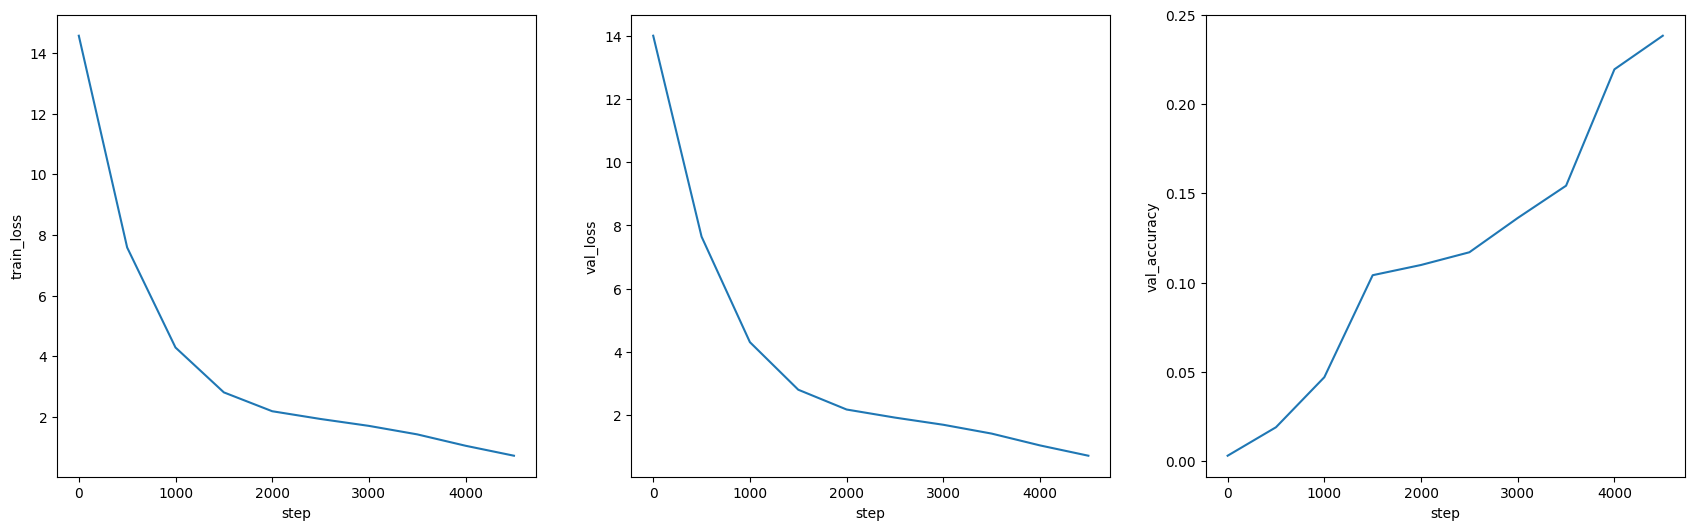

In [15]:
plt.figure(figsize=(7*3, 6))
ax = plt.subplot(1, 3, 1)
plt.plot(list(saves.keys()), [v['train_loss'] for v in saves.values()])
plt.ylabel('train_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 2)
plt.plot(list(saves.keys()), [v['val_loss'] for v in saves.values()])
plt.ylabel('val_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 3)
plt.plot(list(saves.keys()), [v['val_accuracy'] for v in saves.values()])
plt.ylabel('val_accuracy')
plt.xlabel('step')

In [16]:
write_json(saves, out_path=save_path)

## Examine trained model


In [24]:
# saves_loaded = load_json_as_dict('saves')
# saves_loaded = load_json_as_dict('saves_20231016')
# saves_loaded = load_json_as_dict('saves_20231019')
# saves_loaded = load_json_as_dict('saves_best_2023_11_01__00_35_39')
fn_saves = os.path.join('weight_saves', '08_encoder_decoder', '2023_12_07__17_24_39_saves_xscaling')
if not os.path.isfile(fn_saves):
    fn_saves = save_path
saves_loaded = load_json_as_dict(fn_saves)
# saves_loaded = load_json_as_dict(save_path)


def arrayise(d):
    for k, v in d.items():
        if type(v) == dict:
            for kk, vv in v.items():
                d[k][kk] = jnp.array(vv)
    return d


step = list(saves_loaded.keys())[-1]
p = saves_loaded[str(step)]['params']
p = arrayise(p)

i = 0
pred_y = model.apply(p, rng, x[i], call_kwargs={'inference': True, 'logging': False})

pred_y.shape

(1, 128, 6)

In [57]:
pred_y = model.apply(p, rng, x)
if USE_CATEGORICAL:
    pred_y = jnp.argmax(pred_y, axis=1)
saves_loaded.keys()

dict_keys(['0', '500', '1000', '1500', '2000', '2500', '3000', '3500', '4000', '4500'])

The R2 score is  0.16346117288179018
The R2 score with weighted variance is  0.16346117288179018


/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


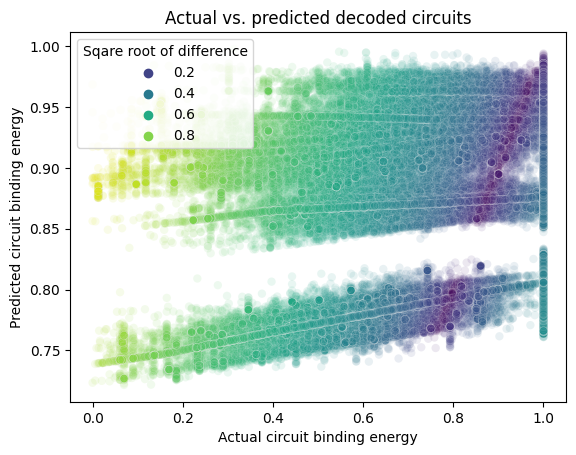

In [59]:
g = sns.scatterplot(x=y.flatten(), y=pred_y.flatten(), alpha=0.1, hue=np.sqrt(np.abs(pred_y.flatten() - y.flatten())), palette='viridis')
g.legend_.set_title('Sqare root of difference')
plt.title(f'Actual vs. predicted decoded circuits')
plt.xlabel('Actual circuit binding energy')
plt.ylabel('Predicted circuit binding energy')
# plt.legend(title='')

print('The R2 score is ', r2_score(y.flatten(), pred_y.flatten()))
print('The R2 score with weighted variance is ', r2_score(
    y.flatten(), pred_y.flatten(), multioutput='variance_weighted'))

Text(0.5, 0, 'Binding energies')

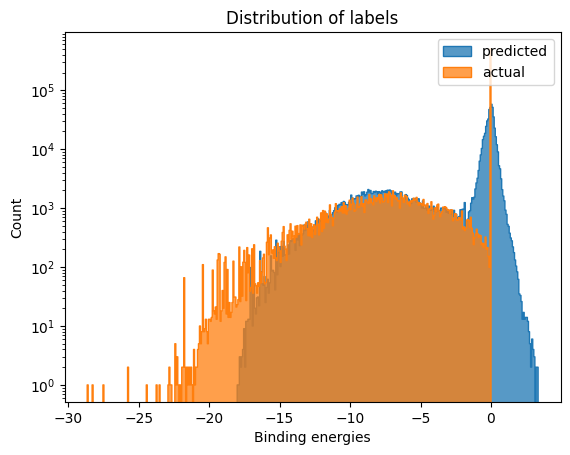

In [23]:

sns.histplot(pred_y.flatten(), label='predicted', element='step', log_scale=[False, True])
sns.histplot(y.flatten(), label='actual', element='step', log_scale=[False, True])
plt.legend()

plt.title('Distribution of labels')
plt.xlabel('Binding energies')